In [15]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from CustomCNN import CNNModel
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

In [51]:
def calculate_saliency_map(image, model):
    image = image.unsqueeze(0) # Add batch dimension and move to appropriate device
    image.requires_grad = True  # Set requires_grad to compute gradients

    # Forward pass through the model
    outputs = model(image)
    prediction = torch.argmax(outputs, dim=1)

    # Backpropagate gradients from the prediction class
    model.zero_grad()  # Clear existing gradients
    prediction.backward()  # Backpropagate gradients

    # Get the gradients from the input image
    gradients = image.grad.detach().cpu().squeeze().numpy()
    
    # Calculate the absolute gradients to emphasize positive contributions
    saliency_map = np.abs(gradients).max(axis=0)  # Compute max across color channels

    # Normalize the saliency map
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    
    return saliency_map

In [2]:
IMAGE_SIZE = 180
image_tensor=transforms.Compose([
        transforms.RandomRotation(30),  # Randomly rotate images in the range (degrees, 0 to 180)
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)), #resize image
        #transforms.RandomResizedCrop(size=(new_size, new_size)),  # Randomly crop and resize images
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # Randomly adjust brightness, contrast, and saturation
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])
    #image is the result of Image.open(file)
    
    
    #transformed_image = image_tensor(image)

In [3]:
model = CNNModel(num_classes=2)

# Load the trained parameters into the model
model.load_state_dict(torch.load('trained_model_32_resize_moreTransformations_acc82.pth'))
model.eval()  # Set the model to evaluation mode
    
print("Model Successfully Loaded!")

Model Successfully Loaded!


In [4]:
model

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=129600, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [18]:
#img = Image.open("uploaded_images/person16_virus_47.jpeg")
img = cv2.imread("uploaded_images/person9_bacteria_41.jpeg")
img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img_rgb = Image.fromarray(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
transformed_image = image_tensor(img_rgb)

In [19]:
transformed_image.size()

torch.Size([3, 180, 180])

In [20]:
image = transformed_image.unsqueeze(0) # Add batch dimension and move to appropriate device
#image.requires_grad = True

In [21]:
image.size()

torch.Size([1, 3, 180, 180])

In [22]:
image.requires_grad = True  # Set requires_grad to compute gradients

# Forward pass through the model
outputs1 = model(image)
prediction1 = torch.argmax(outputs1, dim=1)

In [23]:
image

tensor([[[[-1.5357, -1.5357, -1.5357,  ..., -1.5357, -1.5357, -1.5357],
          [-1.5357, -1.5357, -1.5357,  ..., -1.5357, -1.5357, -1.5357],
          [-1.5357, -1.5357, -1.5357,  ..., -1.5357, -1.5357, -1.5357],
          ...,
          [-1.5357, -1.5357, -1.5357,  ..., -1.5357, -1.5357, -1.5357],
          [-1.5357, -1.5357, -1.5357,  ..., -1.5357, -1.5357, -1.5357],
          [-1.5357, -1.5357, -1.5357,  ..., -1.5357, -1.5357, -1.5357]],

         [[-1.4405, -1.4405, -1.4405,  ..., -1.4405, -1.4405, -1.4405],
          [-1.4405, -1.4405, -1.4405,  ..., -1.4405, -1.4405, -1.4405],
          [-1.4405, -1.4405, -1.4405,  ..., -1.4405, -1.4405, -1.4405],
          ...,
          [-1.4405, -1.4405, -1.4405,  ..., -1.4405, -1.4405, -1.4405],
          [-1.4405, -1.4405, -1.4405,  ..., -1.4405, -1.4405, -1.4405],
          [-1.4405, -1.4405, -1.4405,  ..., -1.4405, -1.4405, -1.4405]],

         [[-1.2119, -1.2119, -1.2119,  ..., -1.2119, -1.2119, -1.2119],
          [-1.2119, -1.2119, -

In [24]:
# Backpropagate gradients from the prediction class
model.zero_grad()  # Clear existing gradients
one_hot_output = torch.zeros(outputs1.size(), dtype=torch.float)
one_hot_output[0][prediction1] = 1.0
outputs1.backward(one_hot_output)  # Backpropagate gradients

In [25]:
# Get the gradients from the input image tensor
gradients = image.grad.detach().cpu().squeeze().numpy()
    
# Calculate the absolute gradients to emphasize positive contributions
saliency_map = np.abs(gradients).max(axis=0)  # Compute max across color channels

# Normalize the saliency map
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

In [26]:
saliency_map

array([[0.10650909, 0.08456599, 0.11007492, ..., 0.06285457, 0.05930406,
        0.07851368],
       [0.21500368, 0.28145006, 0.16444668, ..., 0.1656268 , 0.10038976,
        0.11025451],
       [0.02758691, 0.04544504, 0.01910874, ..., 0.07768281, 0.08410048,
        0.07435842],
       ...,
       [0.13197786, 0.08882991, 0.07575998, ..., 0.17832033, 0.06720803,
        0.07766271],
       [0.17931524, 0.20431152, 0.07073022, ..., 0.07471174, 0.09371049,
        0.07056588],
       [0.12403665, 0.11861768, 0.05774951, ..., 0.08695082, 0.0589419 ,
        0.20122226]], dtype=float32)

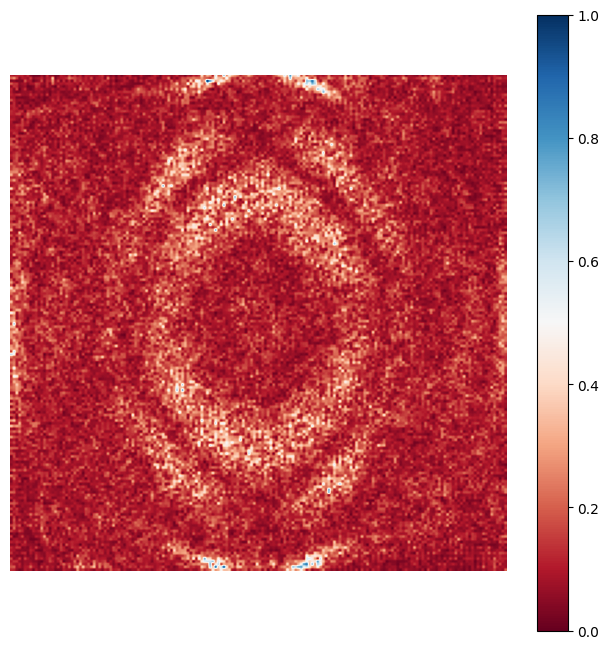

In [27]:
# Create a colormap that ranges from blue to red
cmap = plt.cm.RdBu

# Display the saliency map using matplotlib with blue and red colormap
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap=cmap)
plt.axis('off')
plt.colorbar()  # Add a colorbar for reference
plt.show()

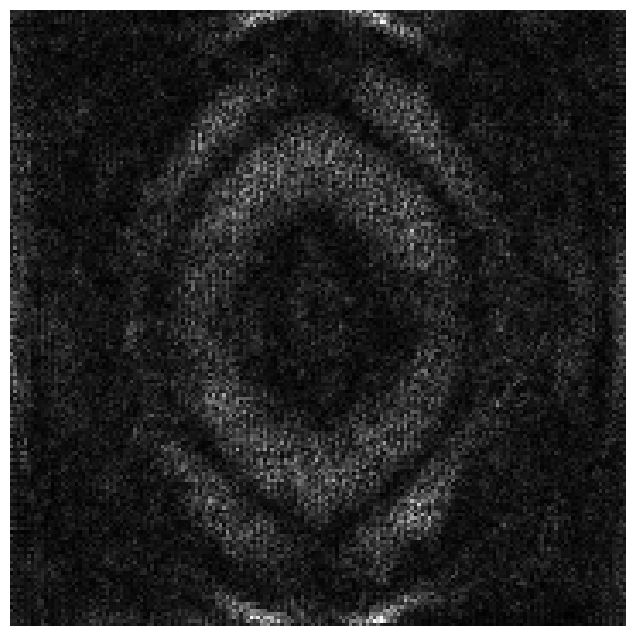

In [16]:
# Convert the saliency map to an RGB image
saliency_map_rgb = cv2.cvtColor((saliency_map * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Display the saliency map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map_rgb)
plt.axis('off')
plt.show()

In [14]:
saliency_map1 = calculate_saliency_map(transformed_image, model)

NameError: name 'calculate_saliency_map' is not defined

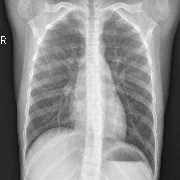

In [30]:
display(img_rgb)

In [31]:
transformed_image = transformed_image[np.newaxis, :]

In [32]:
transformed_image.size()

torch.Size([1, 3, 180, 180])

In [33]:
prob = model(transformed_image)

In [34]:
prob

tensor([[ 1.1378, -1.3890]], grad_fn=<AddmmBackward0>)

In [41]:
softmax = nn.Softmax(dim=1)
softmax_outputs = softmax(prob)
print(softmax_outputs)
_, predicted = torch.max(softmax_outputs, 1)
print(softmax_outputs.squeeze(0)[torch.argmax(softmax_outputs)].item())

tensor([[0.9260, 0.0740]], grad_fn=<SoftmaxBackward0>)
0.9260001182556152


In [43]:
predicted.item()

0